<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/07wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

{{<https://youtu.be/playlist?list=PLQqh36zP38-z7s7FppJtYXFUnJzw88qWg&si=3TuaJ7IiiIG6QT7X>}}

# 2. Imports

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. CNN 핵심레이어 

## A. `torch.nn.ReLU`

## B. `torch.nn.MaxPool2d`

## C. `torch.nn.Conv2d`

**(예시1) 연산방법, stride=2**

In [4]:
img = torch.rand(1,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2)

In [5]:
img

tensor([[[[0.3041, 0.9222, 0.4187, 0.7885],
          [0.7488, 0.5487, 0.7938, 0.0053],
          [0.5002, 0.8596, 0.9975, 0.7992],
          [0.7594, 0.3295, 0.9948, 0.2643]]]])

In [6]:
conv(img)

tensor([[[[0.4708, 0.6137],
          [0.5387, 0.6470]]]], grad_fn=<ConvolutionBackward0>)

??

In [7]:
conv.weight.data, conv.bias.data

(tensor([[[[-0.2970, -0.3377],
           [ 0.0756, -0.1169]]]]),
 tensor([0.4719]))

In [8]:
(img[:,  :,  :2,  :2] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.1281]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [9]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0595]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [10]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0595]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

In [11]:
(img[:,  :,  2:,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0775]),
 tensor([[[[0.1281, 0.0595],
           [0.1877, 0.0775]]]], grad_fn=<ConvolutionBackward0>))

:::{.callout-note}

**입력이 1장의 흑백이미지이고 출력도 1장의 흑백이미지일 경우 컨볼루션 계산과정 요약^[입력shape=(1,1,?,?) 이고 출력의shape=(1,1,?,?)일 경우]**



1. 윈도우생성: `kernel_size` = (?,?) 인 윈도우를 만듦
2. sub-img생성: 입력 이미지에 윈도우를 통과시켜 (?,?) 크기의 sub-img를 만듦.
3. 연산: sub-img의 각 원소에 `conv.weight`의 값을 원소별로 (=element-wisely) 곱하고 결과를 더함. (만약에 `conv.bias`가 있다면 최종결과에 bias를 더함) 
4. 이동&반복: 윈도우를 `stride` 만큼 이동하여 반복. (`stride`=1 이라면 한칸씩, `stride`=2 라면 두칸씩 이동) 

:::

**(예시2)** -- 재현 

"A guide to convolution arithmetic for deep learning"  [@dumoulin2016guide] 에 나온 그림재현 

- ref: <https://arxiv.org/abs/1603.07285> 

![Fig: conv2d 계산과정시각화](https://github.com/guebin/2021BDA/blob/master/_notebooks/2021-11-04-conv.png?raw=true)

In [18]:
img = torch.tensor([
    [3,3,2,1,0],
    [0,0,1,3,1],
    [3,1,2,2,3],
    [2,0,0,2,2],
    [2,0,0,0,1]
]).reshape(1,1,5,5).float()
img

tensor([[[[3., 3., 2., 1., 0.],
          [0., 0., 1., 3., 1.],
          [3., 1., 2., 2., 3.],
          [2., 0., 0., 2., 2.],
          [2., 0., 0., 0., 1.]]]])

In [17]:
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,bias=False)
conv.weight.data = torch.tensor([[[
    [ 0.0, 1.0, 2.0],
    [ 2.0, 2.0, 0.0],
    [ 0.0, 1.0, 2.0]
]]])

In [19]:
conv(img)

tensor([[[[12., 12., 17.],
          [10., 17., 19.],
          [ 9.,  6., 14.]]]], grad_fn=<ConvolutionBackward0>)

**(예시3) 이동평균**

In [33]:
img = torch.arange(1,17).float().reshape(1,1,4,4)
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [27]:
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0 + 1/4
conv.weight.data

tensor([[[[0.2500, 0.2500],
          [0.2500, 0.2500]]]])

In [34]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시4) 2개의 이미지**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 observation 별로 적용 

- `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우와 (n,1,?,?) $\to$ (n,1,?,?)인 경우가 동일 

In [38]:
imgs = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,bias=False)
conv.weight.data = conv.weight.data*0 + 1/4

In [37]:
imgs

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [39]:
conv(imgs)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시5) 2개의 이미지, 2개의 out_channels**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 한번 적용, 그것과 별개로 (1,1,?,?) $\to$ (1,1,?,?) 인 **다른** conv를 적용함. (즉 하나의 observation당 2번 conv변환) 이것을 observation별로 반복

- `conv`에 포함된 파라메터 수는 (n,1,?,?) $\to$ (n,1,?,?) 인 경우보다 (n,1,?,?) $\to$ (n,2,?,?)인 경우가 2배 많음^[bias가 있어도 2배임]

In [92]:
img = torch.arange(1,33).float().reshape(2,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=2,kernel_size=2,stride=1,bias=False)

In [93]:
img

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]],


        [[[17., 18., 19., 20.],
          [21., 22., 23., 24.],
          [25., 26., 27., 28.],
          [29., 30., 31., 32.]]]])

In [94]:
conv.weight.data[0] = conv.weight.data[0]*0 +1/4
conv.weight.data[1] = conv.weight.data[0]*0

In [95]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)

In [80]:
conv(img)

tensor([[[[ 1.2309,  1.2712,  1.3115],
          [ 1.3920,  1.4322,  1.4725],
          [ 1.5530,  1.5933,  1.6335]],

         [[ 3.9083,  4.5405,  5.1728],
          [ 6.4372,  7.0695,  7.7017],
          [ 8.9662,  9.5984, 10.2307]]],


        [[[ 1.8751,  1.9154,  1.9556],
          [ 2.0362,  2.0764,  2.1167],
          [ 2.1972,  2.2375,  2.2777]],

         [[14.0241, 14.6563, 15.2886],
          [16.5530, 17.1853, 17.8175],
          [19.0820, 19.7142, 20.3465]]]], grad_fn=<ConvolutionBackward0>)

# 4. CNN의 학습원리 

## A. data 

아래의 4개의 이미지를 생각하자 .

In [949]:
img0 = torch.tensor([
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]).reshape(1, 1, 16, 16) 
img1 = 0.1-torch.einsum('nchw->ncwh', img0.clone())
img2 = torch.zeros((1, 1, 16, 16))
for i in range(16):
    for j in range(16):
        if j <= i:  # 대각선 아래 삼각형
            img2[0, 0, i, j] = 0.1
# 빈 이미지
img3 = torch.zeros((1, 1, 16, 16))
block_size = 2
# 블록 단위로 채우기
for i in range(0, 16, block_size):
    for j in range(0, 16, block_size):
        if ((i // block_size) + (j // block_size)) % 2 == 0:
            img3[0, 0, i:i+block_size, j:j+block_size] = 0.1

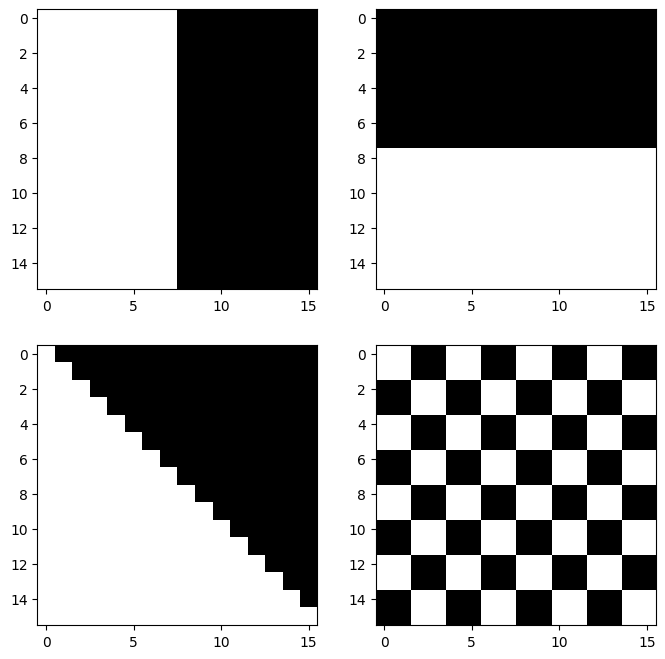

In [950]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(img0.squeeze(),cmap="gray")
axs[0][1].imshow(img1.squeeze(),cmap="gray")
axs[1][0].imshow(img2.squeeze(),cmap="gray")
axs[1][1].imshow(img3.squeeze(),cmap="gray")

In [951]:
imgs = torch.concat([img0,img1,img2,img3],axis=0)
imgs.shape

torch.Size([4, 1, 16, 16])

## B. vertical edge

In [955]:
v_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)

In [956]:
v_conv.weight.data = torch.tensor([[[
    [ 0, 0, 0, 0],
    [ 0, 1.0, -1.0, 0],
    [0, 1.0, -1.0, 0],
    [ 0, 0, 0, 0]
]]])

> 이 `v_conv`는 좌우방향의 픽셀변화, 즉 수직 방향의 엣지(vertical edge)를 감지하는데 적절하다. 

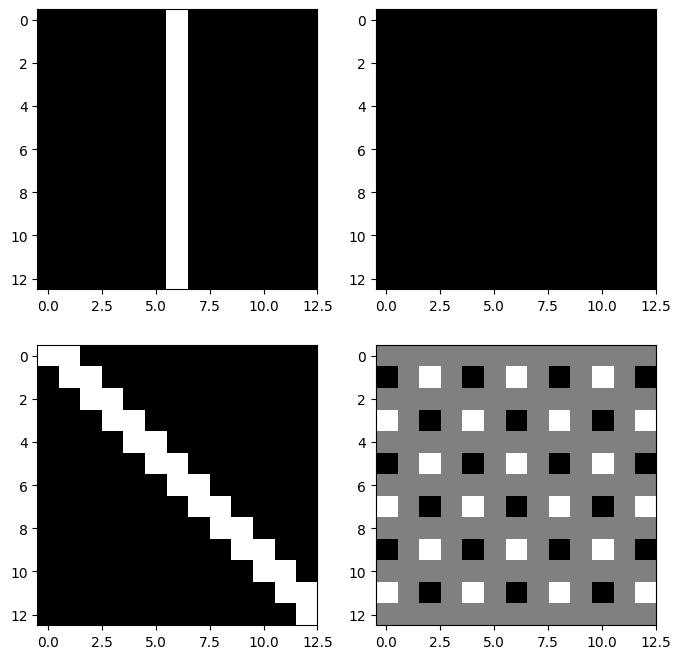

In [954]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(v_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(v_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(v_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(v_conv(imgs)[3].squeeze().data,cmap="gray")

## C. horizontal edge

In [250]:
h_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    bias=False
)

In [251]:
h_conv.weight.data = torch.tensor([[[
    [ 0, 0, 0, 0],
    [ 0, -1.0, -1.0, 0],
    [0, 1.0, 1.0, 0],
    [ 0, 0, 0, 0]
]]])

> 이 `h_conv`는 위아레 방향의 픽셀변화, 즉 수평엣지(horizontal edge)를 감지하는데 적절하다. 

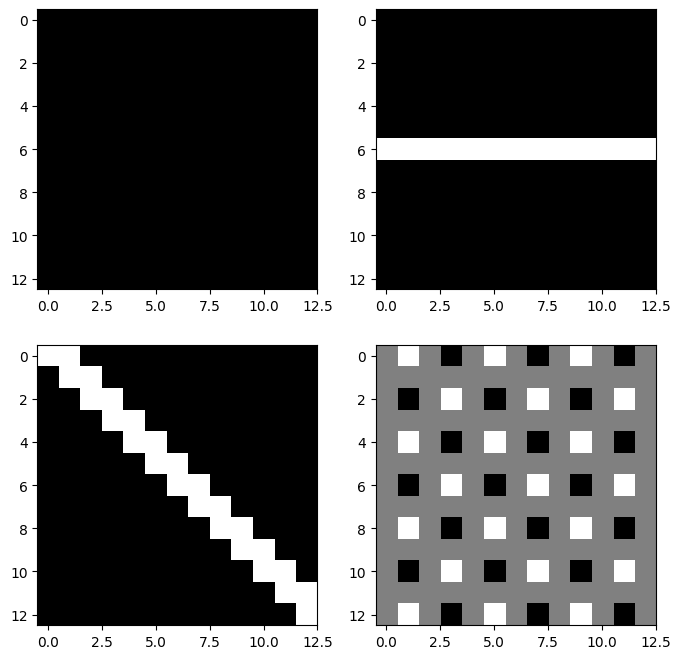

In [259]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(h_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(h_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(h_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(h_conv(imgs)[3].squeeze().data,cmap="gray")

## D. 이동평균

In [987]:
m_conv = torch.nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=4,
)
m_conv.weight.data = m_conv.weight.data*0 + 1/16
m_conv.bias.data = m_conv.bias.data*0 - 0.05

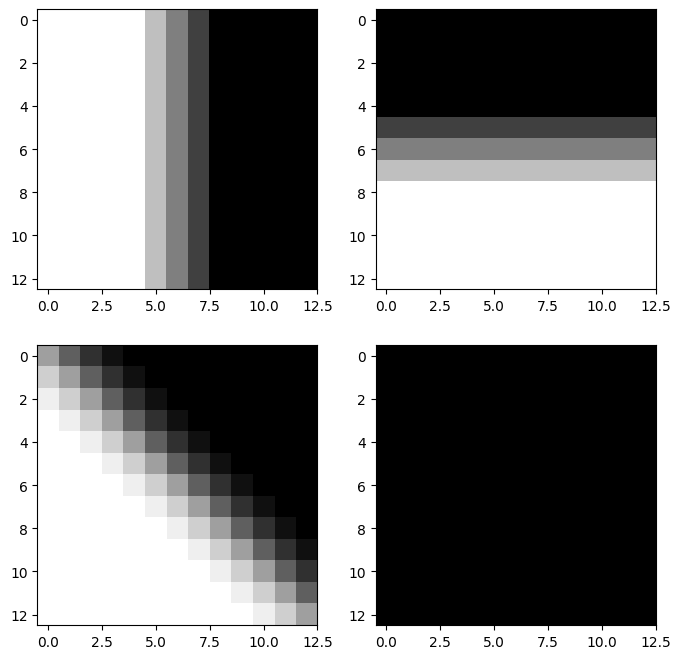

In [988]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(8)
axs[0][0].imshow(m_conv(imgs)[0].squeeze().data,cmap="gray")
axs[0][1].imshow(m_conv(imgs)[1].squeeze().data,cmap="gray")
axs[1][0].imshow(m_conv(imgs)[2].squeeze().data,cmap="gray")
axs[1][1].imshow(m_conv(imgs)[3].squeeze().data,cmap="gray")

## E. (C,D,E) + relu + mp

In [980]:
relu = torch.nn.ReLU()
mp = torch.nn.MaxPool2d(kernel_size=13)

In [981]:
mp(relu(v_conv(imgs)))

tensor([[[[0.200000]]],


        [[[0.000000]]],


        [[[0.100000]]],


        [[[0.200000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [982]:
mp(relu(h_conv(imgs)))

tensor([[[[0.000000]]],


        [[[0.200000]]],


        [[[0.100000]]],


        [[[0.200000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [983]:
mp(relu(m_conv(imgs)))

tensor([[[[2.000000e-01]]],


        [[[2.000000e-01]]],


        [[[2.000000e-01]]],


        [[[3.725290e-09]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

## F. 대충 이런 구조

In [993]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=3,kernel_size=4),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=13),
    torch.nn.Flatten()
)
net[0].weight.data = torch.concat(
    [v_conv.weight.data,
     h_conv.weight.data,
     m_conv.weight.data],axis=0)
net[0].bias.data = torch.tensor([0.0,0.0, -0.05])

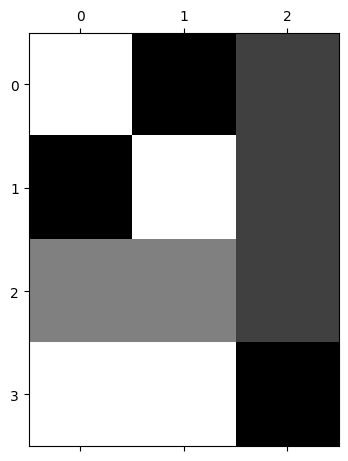

In [994]:
plt.matshow(net(imgs).data,cmap="gray")

In [995]:
net(imgs).shape

torch.Size([4, 3])

> 출력은 (n,3)으로 정리되어서 나온다. 이 시점부터는 더 이상 이미지가 입력이라고 생각하지 않아도 되고, 단순히 (n, 3) 크기의 숫자 데이터가 입력으로 주어진 것처럼 보면 된다.
즉 이제부터는 이 (n,3) 데이터를 입력으로 받는 신경망을 설계하면 된다.

## G. mp의 역할?

`-` 샘플이미지 

In [964]:
img = torch.zeros((1, 1, 16, 16))
triangle_size = 4
for i in range(triangle_size):
    for j in range(triangle_size):
        if j <= i:  # 아래 방향 직각삼각형 (왼쪽 위 꼭짓점 기준)
            img[0, 0, i, j] = 1.0

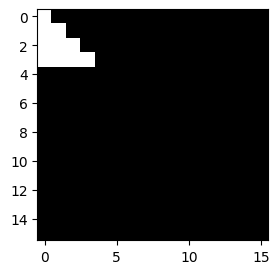

In [965]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp1 회

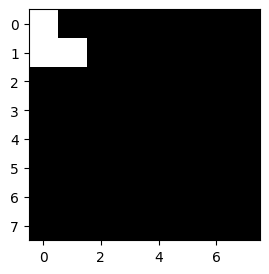

In [966]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(img).squeeze(),cmap="gray")

`-` mp 2~4회 

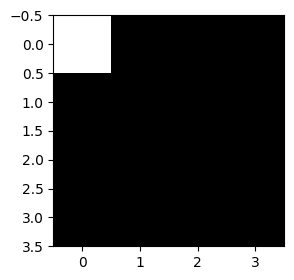

In [967]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(mp(img)).squeeze(),cmap="gray")

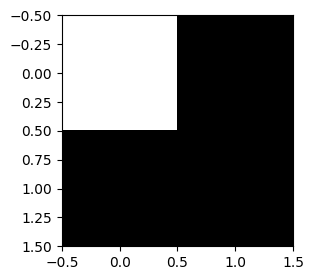

In [968]:
mp = torch.nn.MaxPool2d(kernel_size=2)
plt.imshow(mp(mp(mp(img))).squeeze(),cmap="gray")

`-` maxpooling은 이미지를 "캐리커처화" 한다고 비유할 수 있음. 디테일은 버리고, 중요한 특징만 뽑아서 과장되게 요약한다. 

# 5. FashionMNIST

`-` 데이터

In [969]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset]).to("cuda:0")
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float().to("cuda:0")

`-` 2d를 처리하고 flatten하는 네트워크 

In [970]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Flatten()
).to("cuda:0")

In [971]:
net1(X).shape

torch.Size([5000, 2304])

> 출력은 (n,2304)으로 정리되어서 나온다. 이 시점부터는 더 이상 이미지가 입력이라고 생각하지 않아도 되고, 단순히 (n, 2304) 크기의 숫자 데이터가 입력으로 주어진 것처럼 보면 된다. 즉 이제부터는 이 (n,2304) 데이터를 입력으로 받는 신경망을 설계하면 된다.

`-` 1d를 처리하는 네트워크

In [972]:
net2= torch.nn.Sequential(
    torch.nn.Linear(2304,10),
).to("cuda:0")

In [973]:
net2(net1(X)).shape

torch.Size([5000, 10])

`-` 두 네트워크를 결합 

In [974]:
net = torch.nn.Sequential(
    net1,
    net2
)
net(X).shape

torch.Size([5000, 10])

`-` 최종적인 코드 

In [975]:
net = torch.nn.Sequential(
    net1,
    net2
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr=torch.optim.Adam(net.parameters())
#---#
for epoc in range(100):
    #1
    netout = net(X)
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [976]:
(net(X).argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.883800, device='cuda:0')